### 초기 경로 설정 (클래스 이용을 위함)

In [5]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [6]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [7]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [8]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [9]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/torch_sm/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [10]:
train_images = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/images/*')
train_labels = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))


My custom training-dataset has 366 elements
My custom valing-dataset has 123 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

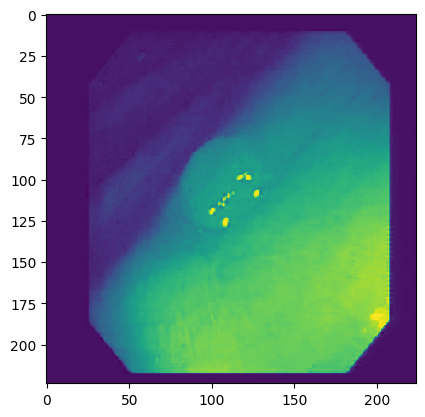

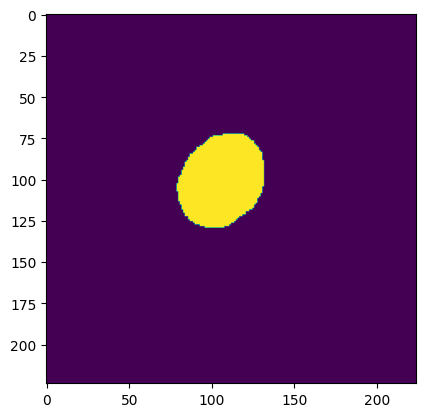

3픽셀의 평균값이라 색깔이 변경됨.


In [11]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [12]:
# Begin training
from models.nnUNet.nnunet import Nested_UNet as UNet_2p
model = UNet_2p(1,3)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [13]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [14]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'UNet++'
data_name = 'CVC'

# 5. Training

 Epoch: 1 of 100, Iter.: 46 of 46, Train Loss: 1.307517, IoU: 0.252244, Dice: 0.361849
 Epoch: 1 of 100, Iter.: 46 of 46, Valid Loss: 1.310649, IoU: 0.158353, Dice: 0.236718

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


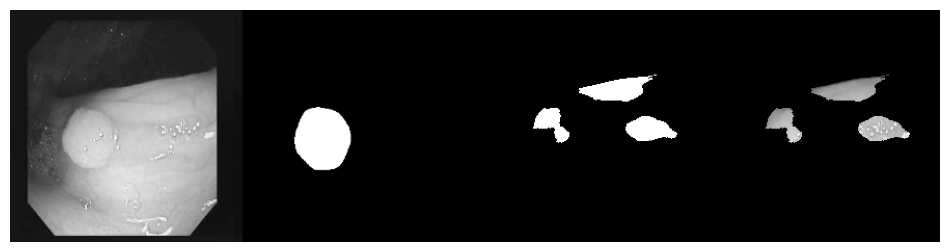

 Epoch: 2 of 100, Iter.: 46 of 46, Train Loss: 1.192395, IoU: 0.306322, Dice: 0.415224
 Epoch: 2 of 100, Iter.: 46 of 46, Valid Loss: 1.219558, IoU: 0.291222, Dice: 0.400011


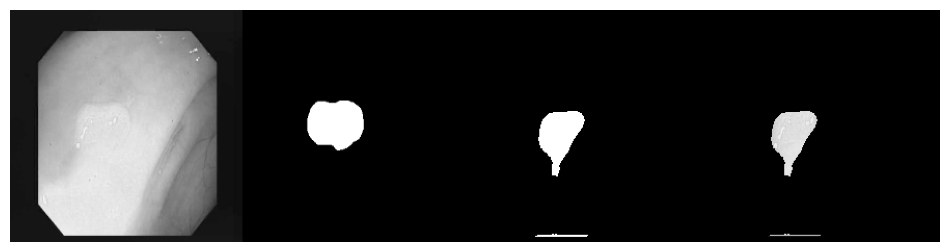

 Epoch: 3 of 100, Iter.: 46 of 46, Train Loss: 1.133894, IoU: 0.368329, Dice: 0.484923
 Epoch: 3 of 100, Iter.: 46 of 46, Valid Loss: 1.160506, IoU: 0.316132, Dice: 0.425847


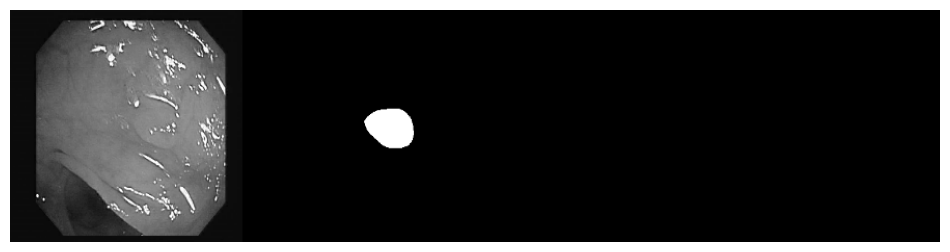

 Epoch: 4 of 100, Iter.: 46 of 46, Train Loss: 1.099374, IoU: 0.401461, Dice: 0.520483
 Epoch: 4 of 100, Iter.: 46 of 46, Valid Loss: 1.121479, IoU: 0.312228, Dice: 0.414403


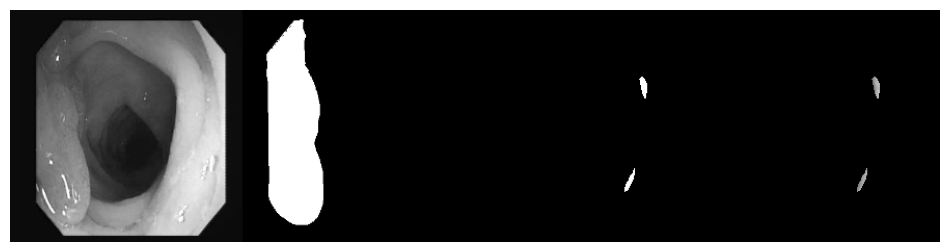

 Epoch: 5 of 100, Iter.: 46 of 46, Train Loss: 1.056191, IoU: 0.427106, Dice: 0.540523
 Epoch: 5 of 100, Iter.: 46 of 46, Valid Loss: 1.125262, IoU: 0.355201, Dice: 0.484804


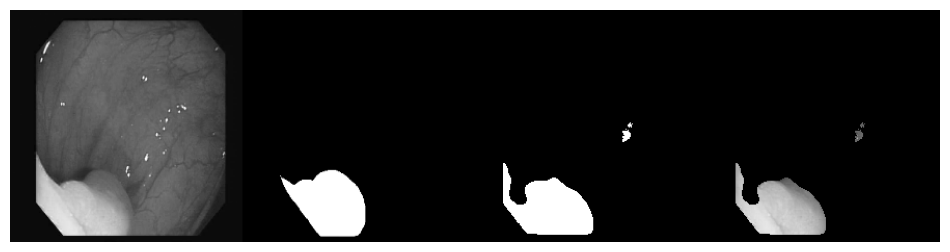

 Epoch: 6 of 100, Iter.: 46 of 46, Train Loss: 1.020552, IoU: 0.452527, Dice: 0.566740
 Epoch: 6 of 100, Iter.: 46 of 46, Valid Loss: 1.083640, IoU: 0.394873, Dice: 0.515612


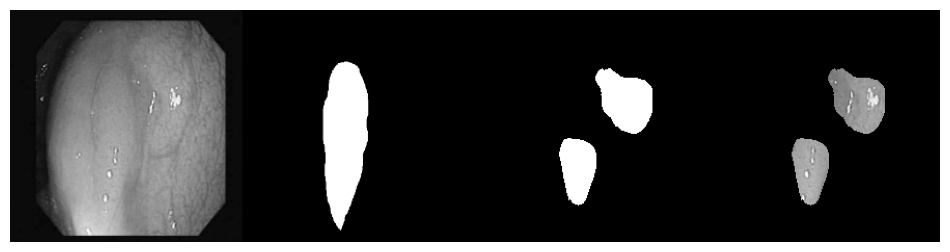

 Epoch: 7 of 100, Iter.: 46 of 46, Train Loss: 0.968251, IoU: 0.525007, Dice: 0.637358
 Epoch: 7 of 100, Iter.: 46 of 46, Valid Loss: 1.043630, IoU: 0.422761, Dice: 0.539454


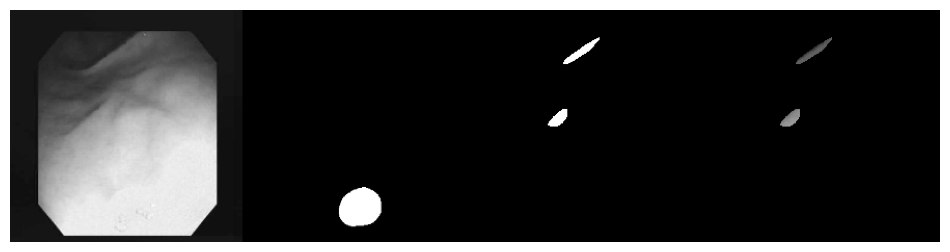

 Epoch: 8 of 100, Iter.: 46 of 46, Train Loss: 0.950858, IoU: 0.536756, Dice: 0.648596
 Epoch: 8 of 100, Iter.: 46 of 46, Valid Loss: 1.042542, IoU: 0.391820, Dice: 0.505742


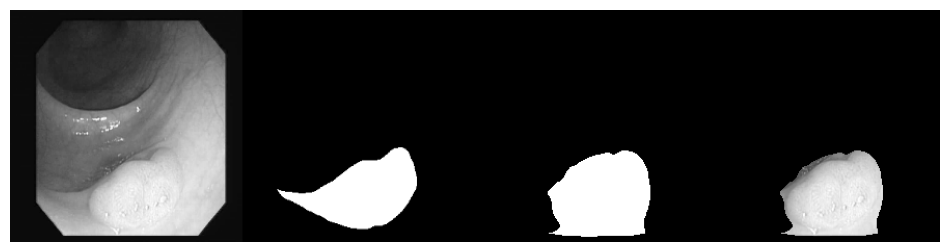

 Epoch: 9 of 100, Iter.: 46 of 46, Train Loss: 0.904956, IoU: 0.580598, Dice: 0.688777
 Epoch: 9 of 100, Iter.: 46 of 46, Valid Loss: 1.000494, IoU: 0.474173, Dice: 0.575649


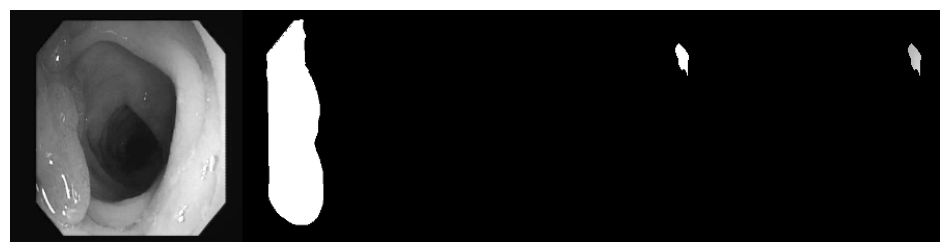

 Epoch: 10 of 100, Iter.: 46 of 46, Train Loss: 0.864779, IoU: 0.620734, Dice: 0.720997
 Epoch: 10 of 100, Iter.: 46 of 46, Valid Loss: 0.996412, IoU: 0.396855, Dice: 0.494821


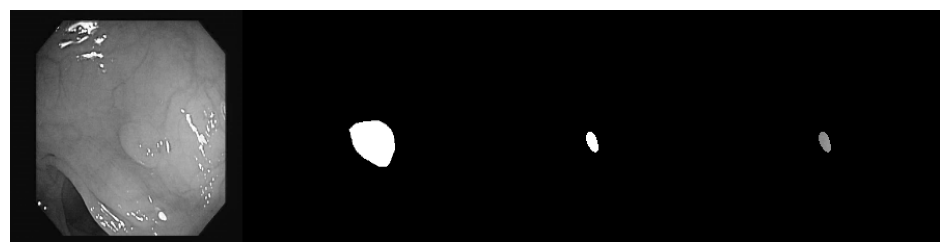

 Epoch: 11 of 100, Iter.: 46 of 46, Train Loss: 0.840233, IoU: 0.634940, Dice: 0.738013
 Epoch: 11 of 100, Iter.: 46 of 46, Valid Loss: 0.934556, IoU: 0.494820, Dice: 0.595856


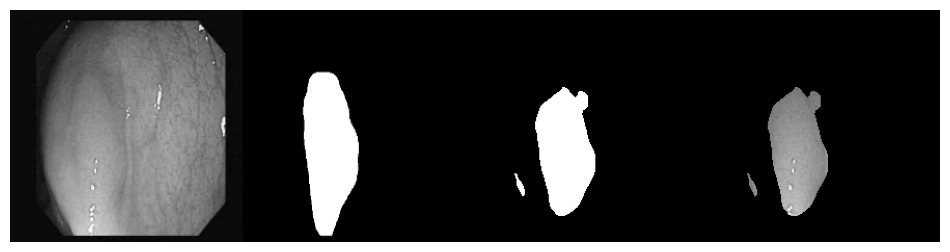

 Epoch: 12 of 100, Iter.: 46 of 46, Train Loss: 0.798092, IoU: 0.679295, Dice: 0.774484
 Epoch: 12 of 100, Iter.: 46 of 46, Valid Loss: 0.890626, IoU: 0.557274, Dice: 0.673720


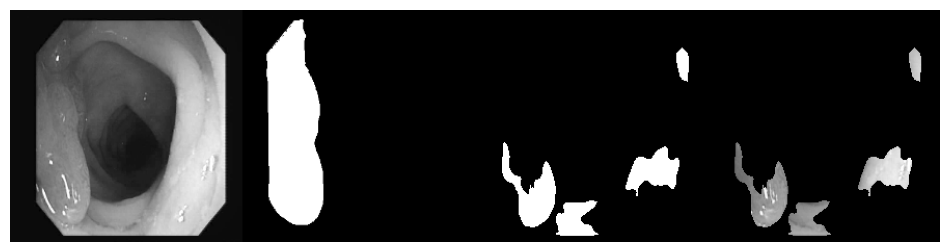

 Epoch: 13 of 100, Iter.: 46 of 46, Train Loss: 0.770157, IoU: 0.683190, Dice: 0.778735
 Epoch: 13 of 100, Iter.: 46 of 46, Valid Loss: 0.884386, IoU: 0.548557, Dice: 0.652166


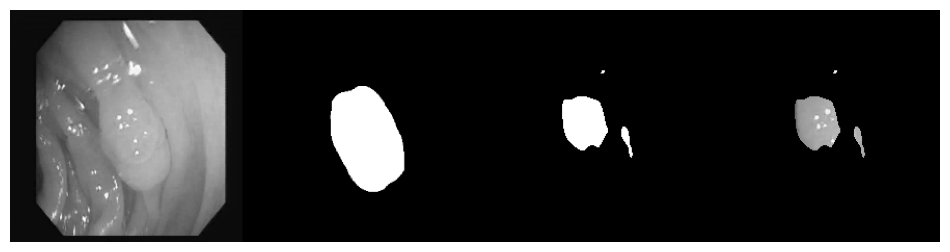

 Epoch: 14 of 100, Iter.: 46 of 46, Train Loss: 0.743218, IoU: 0.702278, Dice: 0.796848
 Epoch: 14 of 100, Iter.: 46 of 46, Valid Loss: 0.878903, IoU: 0.500129, Dice: 0.590520


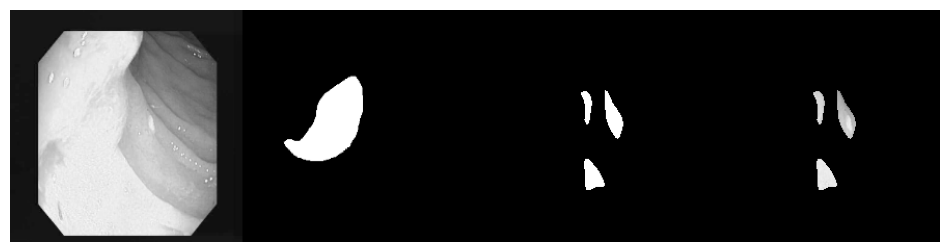

 Epoch: 15 of 100, Iter.: 46 of 46, Train Loss: 0.728106, IoU: 0.695156, Dice: 0.789110
 Epoch: 15 of 100, Iter.: 46 of 46, Valid Loss: 0.913263, IoU: 0.403687, Dice: 0.488552


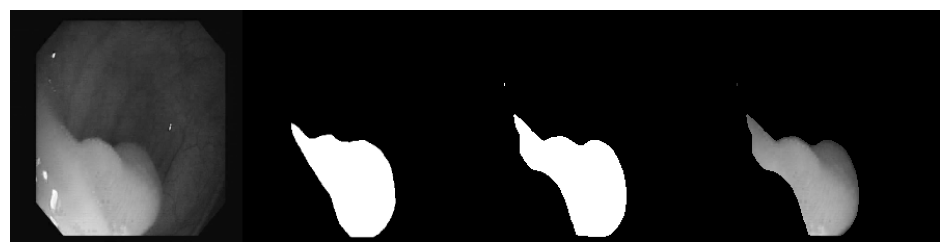

 Epoch: 16 of 100, Iter.: 46 of 46, Train Loss: 0.696746, IoU: 0.730264, Dice: 0.817394
 Epoch: 16 of 100, Iter.: 46 of 46, Valid Loss: 0.796321, IoU: 0.580749, Dice: 0.663038


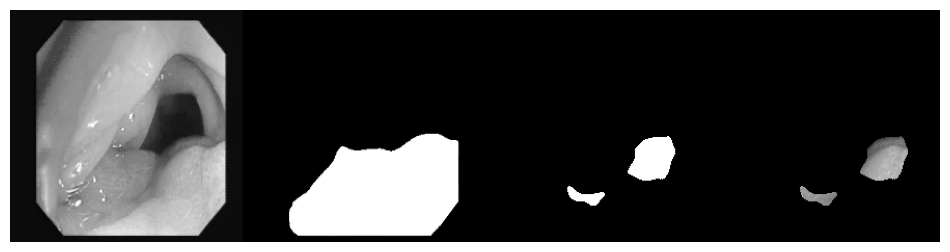

 Epoch: 17 of 100, Iter.: 46 of 46, Train Loss: 0.643593, IoU: 0.783078, Dice: 0.857282
 Epoch: 17 of 100, Iter.: 46 of 46, Valid Loss: 0.768707, IoU: 0.637200, Dice: 0.726159


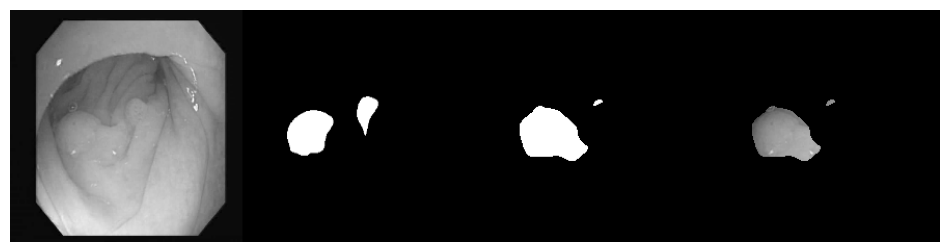

 Epoch: 18 of 100, Iter.: 46 of 46, Train Loss: 0.616439, IoU: 0.804918, Dice: 0.871402
 Epoch: 18 of 100, Iter.: 46 of 46, Valid Loss: 0.744171, IoU: 0.593328, Dice: 0.685855


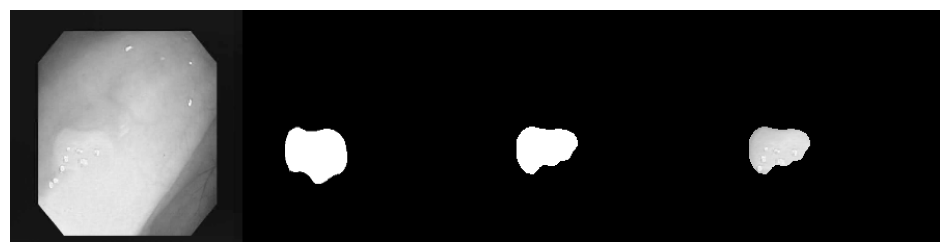

 Epoch: 19 of 100, Iter.: 46 of 46, Train Loss: 0.594497, IoU: 0.817719, Dice: 0.883750
 Epoch: 19 of 100, Iter.: 46 of 46, Valid Loss: 0.760119, IoU: 0.563990, Dice: 0.647275


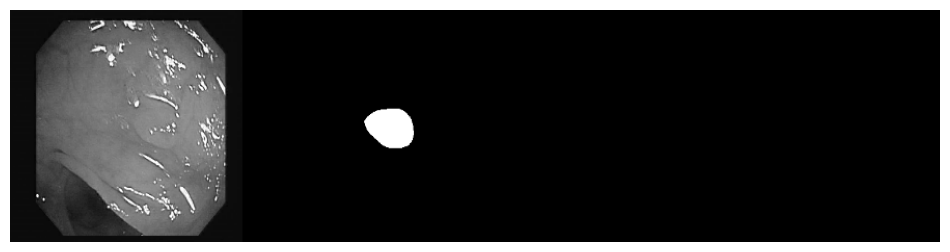

 Epoch: 20 of 100, Iter.: 46 of 46, Train Loss: 0.562391, IoU: 0.824983, Dice: 0.889791
 Epoch: 20 of 100, Iter.: 46 of 46, Valid Loss: 0.713945, IoU: 0.626905, Dice: 0.719569


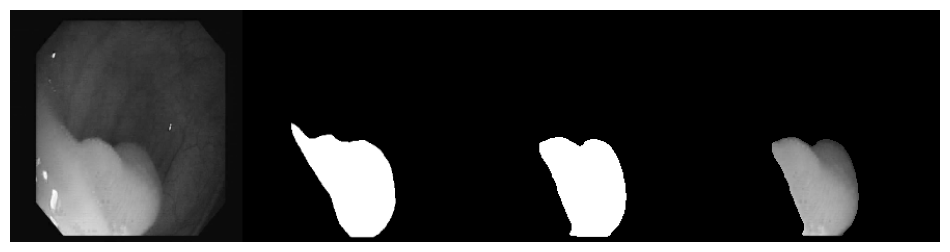

 Epoch: 21 of 100, Iter.: 46 of 46, Train Loss: 0.551592, IoU: 0.825795, Dice: 0.889686
 Epoch: 21 of 100, Iter.: 46 of 46, Valid Loss: 0.678404, IoU: 0.635522, Dice: 0.720510


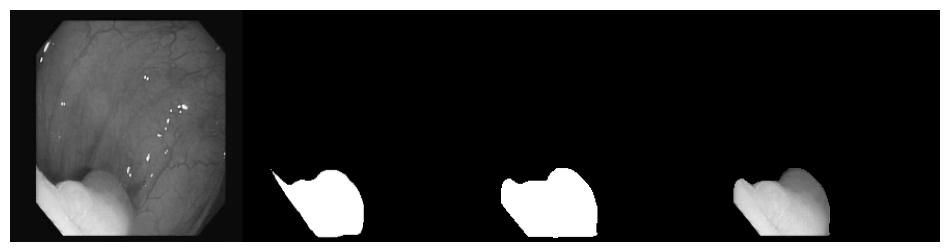

 Epoch: 22 of 100, Iter.: 46 of 46, Train Loss: 0.546236, IoU: 0.797790, Dice: 0.868080
 Epoch: 22 of 100, Iter.: 46 of 46, Valid Loss: 0.734612, IoU: 0.573117, Dice: 0.675258


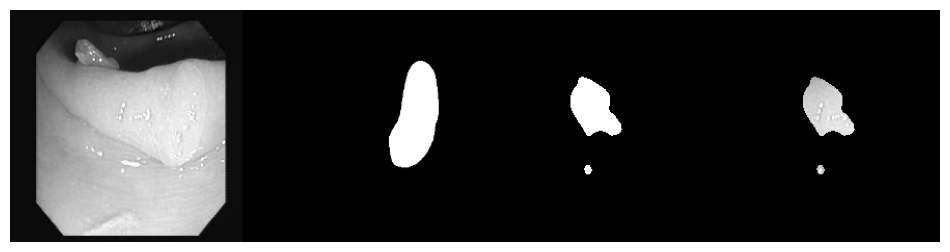

 Epoch: 23 of 100, Iter.: 46 of 46, Train Loss: 0.532641, IoU: 0.796526, Dice: 0.869482
 Epoch: 23 of 100, Iter.: 46 of 46, Valid Loss: 0.788127, IoU: 0.493830, Dice: 0.603805


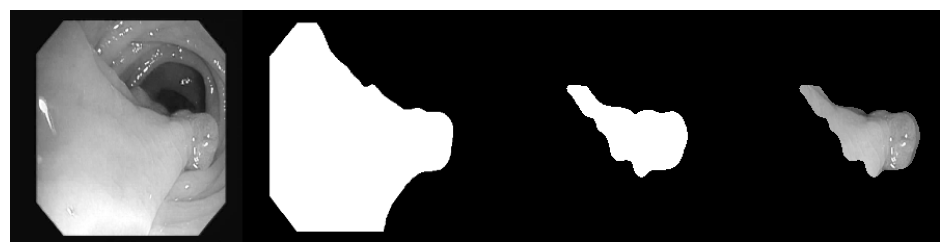

 Epoch: 24 of 100, Iter.: 46 of 46, Train Loss: 0.508306, IoU: 0.800658, Dice: 0.869062
 Epoch: 24 of 100, Iter.: 46 of 46, Valid Loss: 0.655449, IoU: 0.645740, Dice: 0.733829


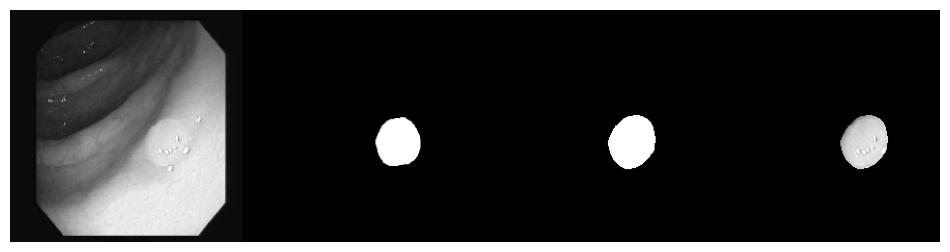

 Epoch: 25 of 100, Iter.: 46 of 46, Train Loss: 0.482617, IoU: 0.819833, Dice: 0.885696
 Epoch: 25 of 100, Iter.: 46 of 46, Valid Loss: 0.681154, IoU: 0.566822, Dice: 0.666213


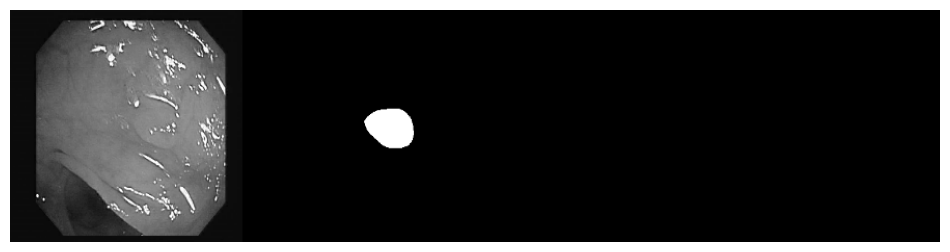

 Epoch: 26 of 100, Iter.: 46 of 46, Train Loss: 0.474202, IoU: 0.804245, Dice: 0.874073
 Epoch: 26 of 100, Iter.: 46 of 46, Valid Loss: 0.677946, IoU: 0.521250, Dice: 0.609749


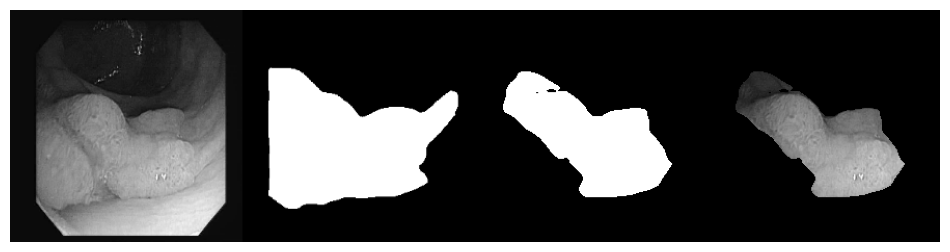

 Epoch: 27 of 100, Iter.: 46 of 46, Train Loss: 0.443732, IoU: 0.834540, Dice: 0.896458
 Epoch: 27 of 100, Iter.: 46 of 46, Valid Loss: 0.692190, IoU: 0.514627, Dice: 0.605373


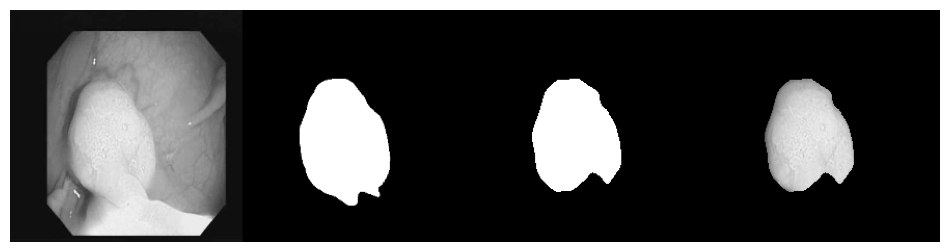

 Epoch: 28 of 100, Iter.: 46 of 46, Train Loss: 0.430155, IoU: 0.839653, Dice: 0.901035
 Epoch: 28 of 100, Iter.: 46 of 46, Valid Loss: 0.601415, IoU: 0.621391, Dice: 0.714047


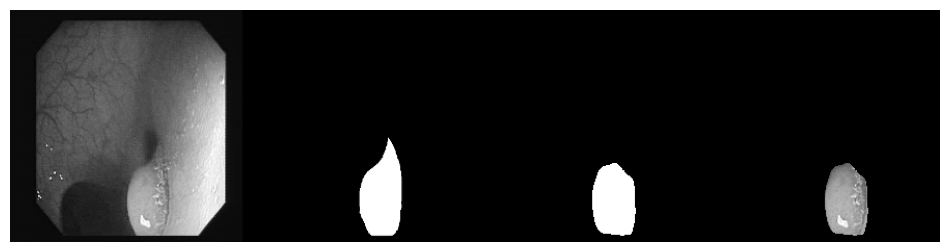

 Epoch: 29 of 100, Iter.: 46 of 46, Train Loss: 0.400025, IoU: 0.860215, Dice: 0.911719
 Epoch: 29 of 100, Iter.: 46 of 46, Valid Loss: 0.582069, IoU: 0.633828, Dice: 0.725006


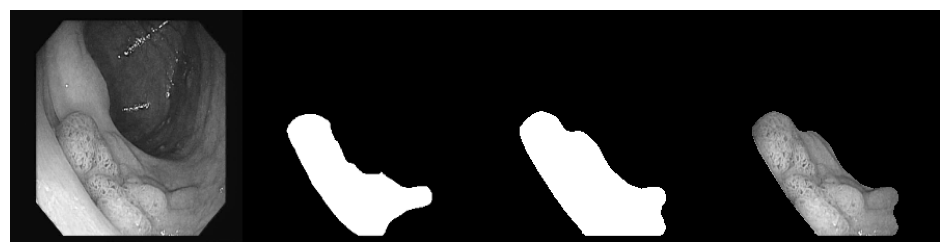

 Epoch: 30 of 100, Iter.: 46 of 46, Train Loss: 0.370907, IoU: 0.879471, Dice: 0.926638
 Epoch: 30 of 100, Iter.: 46 of 46, Valid Loss: 0.571254, IoU: 0.619451, Dice: 0.702485


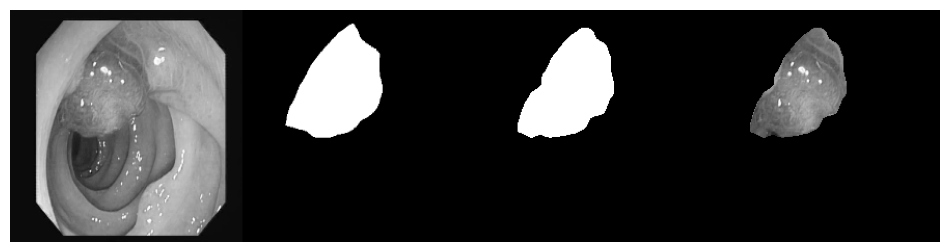

 Epoch: 31 of 100, Iter.: 46 of 46, Train Loss: 0.353514, IoU: 0.892650, Dice: 0.935396
 Epoch: 31 of 100, Iter.: 46 of 46, Valid Loss: 0.546973, IoU: 0.666294, Dice: 0.743935


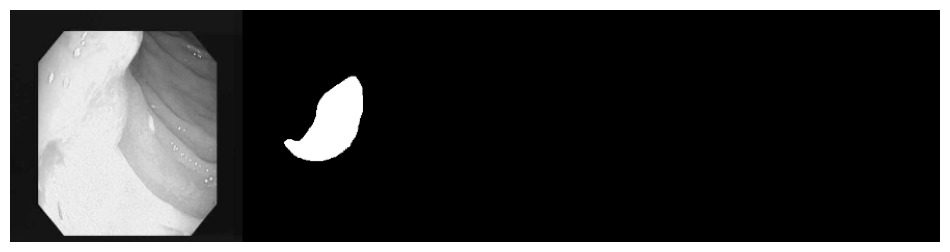

 Epoch: 32 of 100, Iter.: 46 of 46, Train Loss: 0.339092, IoU: 0.896562, Dice: 0.938431
 Epoch: 32 of 100, Iter.: 46 of 46, Valid Loss: 0.518998, IoU: 0.670412, Dice: 0.747402


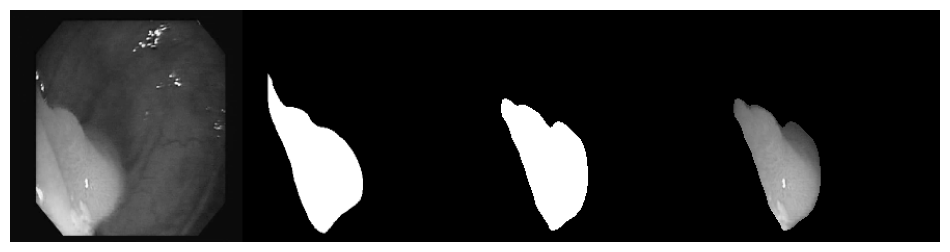

 Epoch: 33 of 100, Iter.: 46 of 46, Train Loss: 0.324693, IoU: 0.900109, Dice: 0.940484
 Epoch: 33 of 100, Iter.: 46 of 46, Valid Loss: 0.517677, IoU: 0.660084, Dice: 0.740858


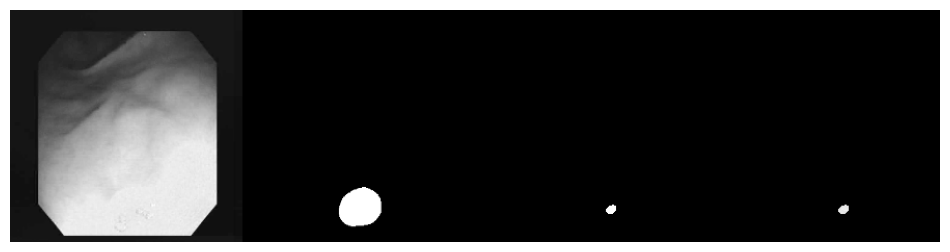

 Epoch: 34 of 100, Iter.: 46 of 46, Train Loss: 0.306958, IoU: 0.908041, Dice: 0.945010
 Epoch: 34 of 100, Iter.: 46 of 46, Valid Loss: 0.493143, IoU: 0.682383, Dice: 0.764919


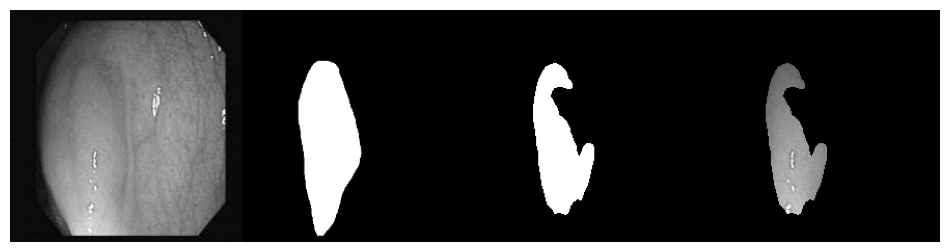

 Epoch: 35 of 100, Iter.: 46 of 46, Train Loss: 0.295797, IoU: 0.911455, Dice: 0.946150
 Epoch: 35 of 100, Iter.: 46 of 46, Valid Loss: 0.494276, IoU: 0.661990, Dice: 0.741235


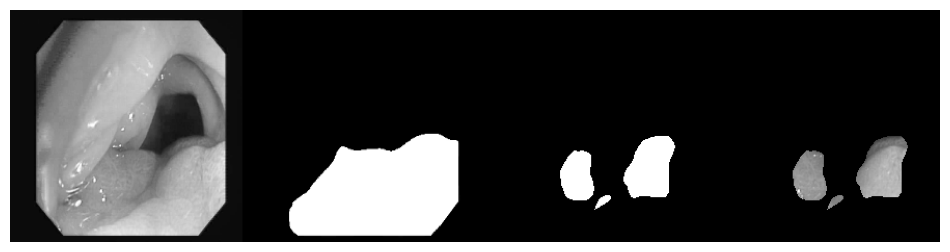

 Epoch: 36 of 100, Iter.: 46 of 46, Train Loss: 0.275655, IoU: 0.917537, Dice: 0.950073
 Epoch: 36 of 100, Iter.: 46 of 46, Valid Loss: 0.478768, IoU: 0.681212, Dice: 0.762761


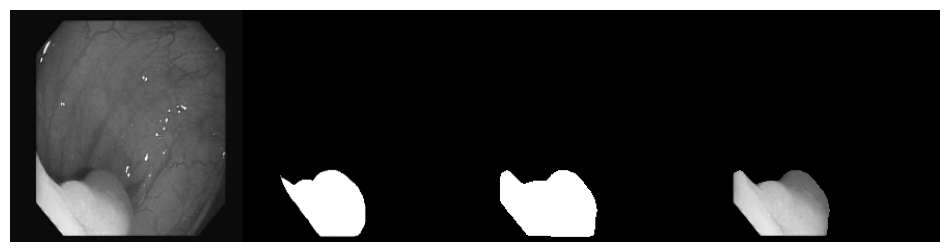

 Epoch: 37 of 100, Iter.: 46 of 46, Train Loss: 0.263882, IoU: 0.922731, Dice: 0.953464
 Epoch: 37 of 100, Iter.: 46 of 46, Valid Loss: 0.461286, IoU: 0.681095, Dice: 0.762358


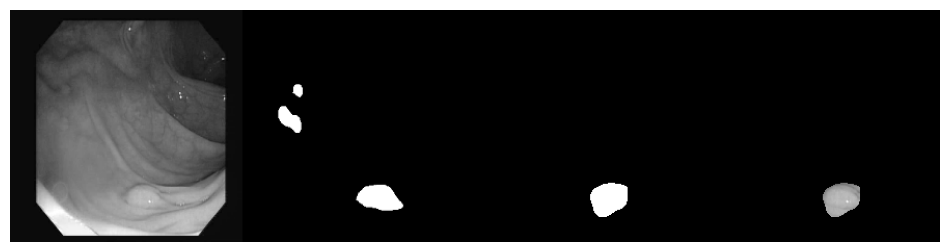

 Epoch: 38 of 100, Iter.: 46 of 46, Train Loss: 0.249925, IoU: 0.923534, Dice: 0.953881
 Epoch: 38 of 100, Iter.: 46 of 46, Valid Loss: 0.457691, IoU: 0.668278, Dice: 0.750656


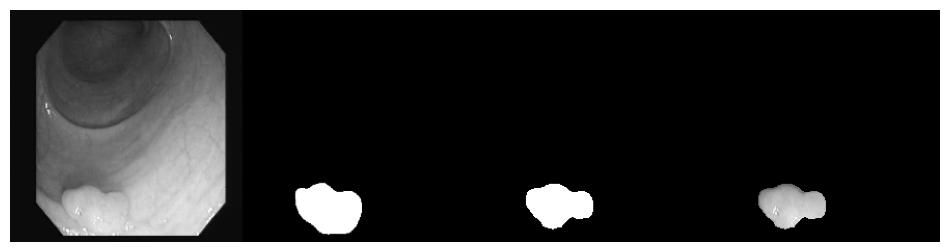

 Epoch: 39 of 100, Iter.: 46 of 46, Train Loss: 0.244188, IoU: 0.921430, Dice: 0.952700
 Epoch: 39 of 100, Iter.: 46 of 46, Valid Loss: 0.451552, IoU: 0.685535, Dice: 0.766629


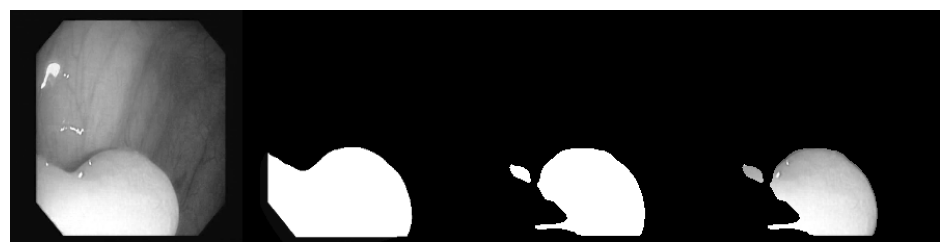

 Epoch: 40 of 100, Iter.: 46 of 46, Train Loss: 0.234967, IoU: 0.921510, Dice: 0.952718
 Epoch: 40 of 100, Iter.: 46 of 46, Valid Loss: 0.452936, IoU: 0.674787, Dice: 0.755619


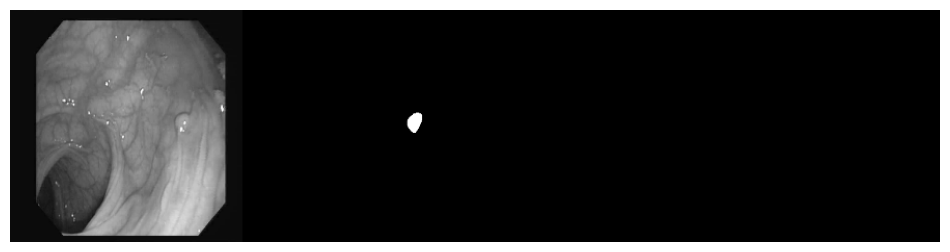

 Epoch: 41 of 100, Iter.: 46 of 46, Train Loss: 0.217030, IoU: 0.930297, Dice: 0.957545
 Epoch: 41 of 100, Iter.: 46 of 46, Valid Loss: 0.428201, IoU: 0.684320, Dice: 0.763183


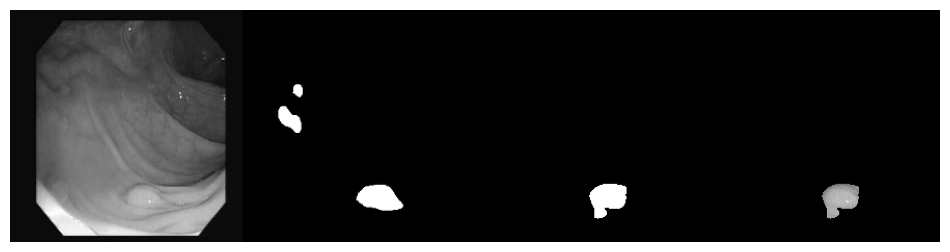

 Epoch: 42 of 100, Iter.: 46 of 46, Train Loss: 0.211432, IoU: 0.929927, Dice: 0.957513
 Epoch: 42 of 100, Iter.: 46 of 46, Valid Loss: 0.441888, IoU: 0.662655, Dice: 0.744703


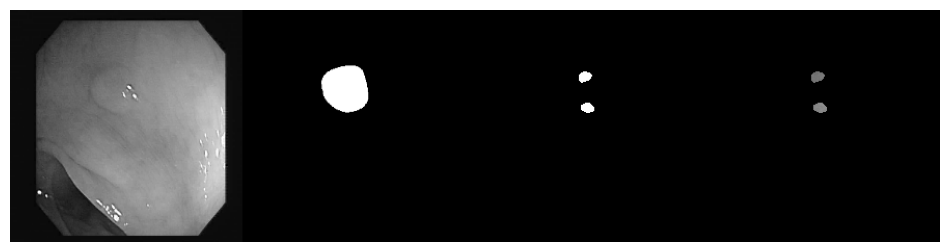

 Epoch: 43 of 100, Iter.: 46 of 46, Train Loss: 0.205735, IoU: 0.929315, Dice: 0.957000
 Epoch: 43 of 100, Iter.: 46 of 46, Valid Loss: 0.434912, IoU: 0.673840, Dice: 0.758187


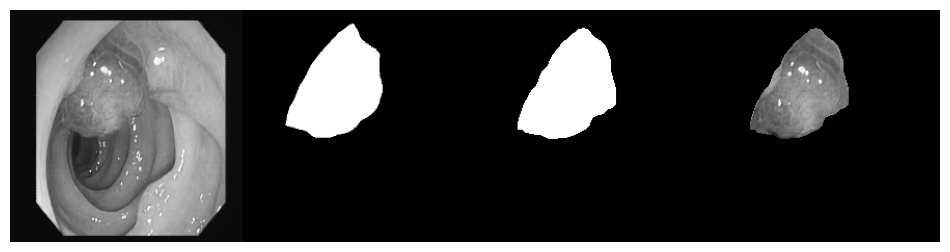

 Epoch: 44 of 100, Iter.: 46 of 46, Train Loss: 0.199387, IoU: 0.930418, Dice: 0.957699
 Epoch: 44 of 100, Iter.: 46 of 46, Valid Loss: 0.417992, IoU: 0.674953, Dice: 0.753029


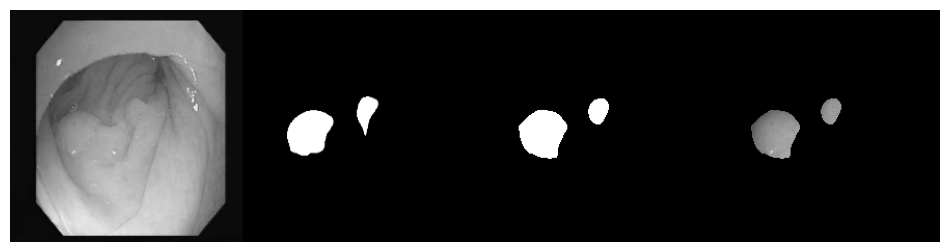

 Epoch: 45 of 100, Iter.: 46 of 46, Train Loss: 0.195926, IoU: 0.913173, Dice: 0.945388
 Epoch: 45 of 100, Iter.: 46 of 46, Valid Loss: 0.585528, IoU: 0.559036, Dice: 0.672027


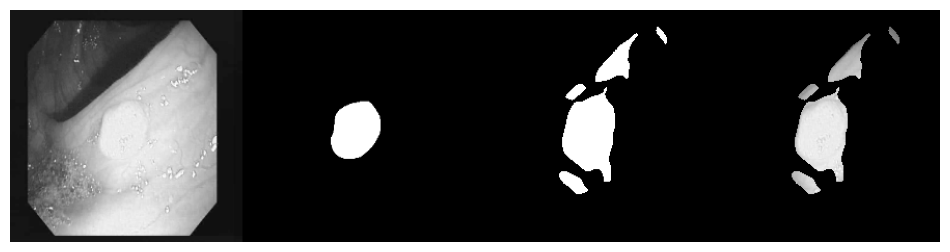

 Epoch: 46 of 100, Iter.: 46 of 46, Train Loss: 0.276433, IoU: 0.791788, Dice: 0.861422
 Epoch: 46 of 100, Iter.: 46 of 46, Valid Loss: 0.818392, IoU: 0.375040, Dice: 0.502347


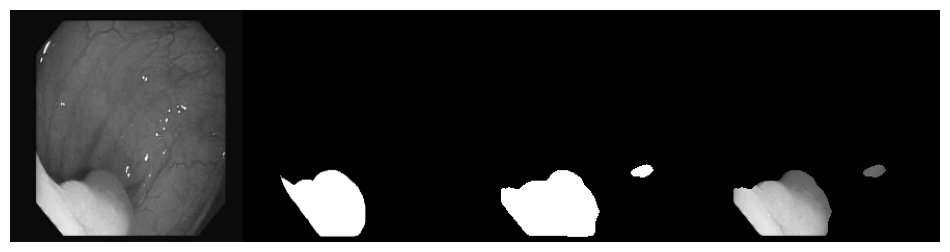

 Epoch: 47 of 100, Iter.: 46 of 46, Train Loss: 0.337425, IoU: 0.709661, Dice: 0.795046
 Epoch: 47 of 100, Iter.: 46 of 46, Valid Loss: 0.533341, IoU: 0.564941, Dice: 0.672918


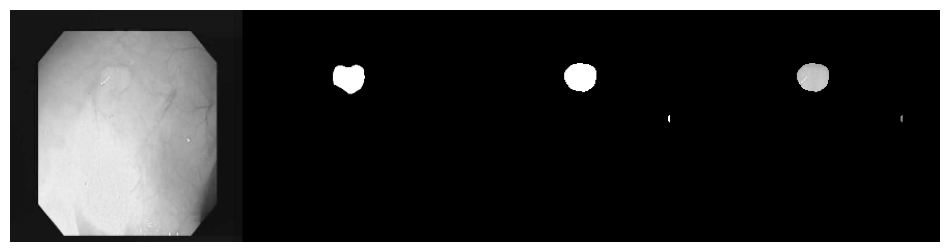

 Epoch: 48 of 100, Iter.: 46 of 46, Train Loss: 0.237977, IoU: 0.831302, Dice: 0.892458
 Epoch: 48 of 100, Iter.: 46 of 46, Valid Loss: 0.426856, IoU: 0.639400, Dice: 0.722802


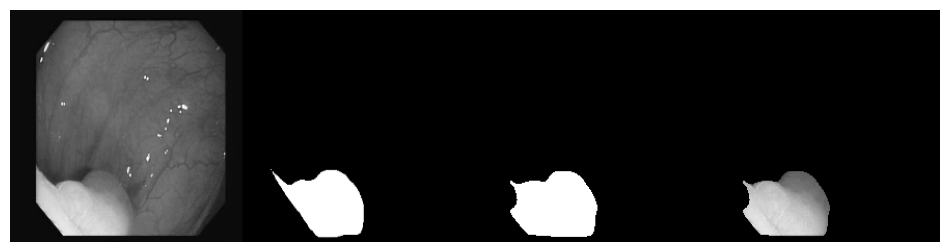

 Epoch: 49 of 100, Iter.: 46 of 46, Train Loss: 0.199207, IoU: 0.874579, Dice: 0.922606
 Epoch: 49 of 100, Iter.: 46 of 46, Valid Loss: 0.472433, IoU: 0.637402, Dice: 0.725442


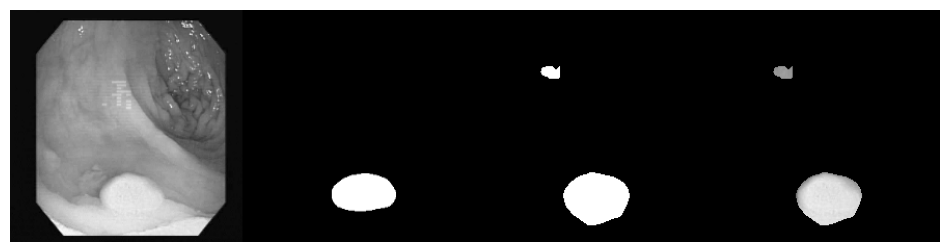

 Epoch: 50 of 100, Iter.: 46 of 46, Train Loss: 0.215482, IoU: 0.833054, Dice: 0.888525
 Epoch: 50 of 100, Iter.: 46 of 46, Valid Loss: 0.472962, IoU: 0.596867, Dice: 0.686802


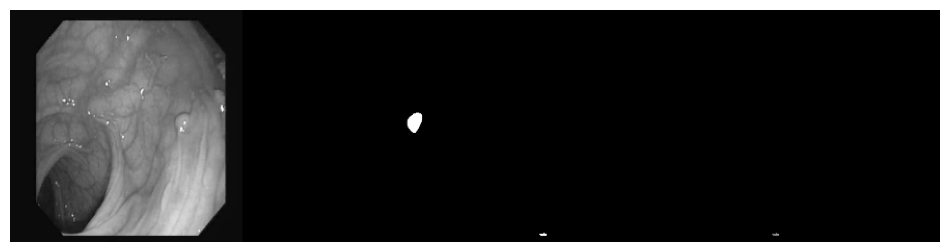

 Epoch: 51 of 100, Iter.: 46 of 46, Train Loss: 0.194980, IoU: 0.867237, Dice: 0.916159
 Epoch: 51 of 100, Iter.: 46 of 46, Valid Loss: 0.396869, IoU: 0.657413, Dice: 0.743271


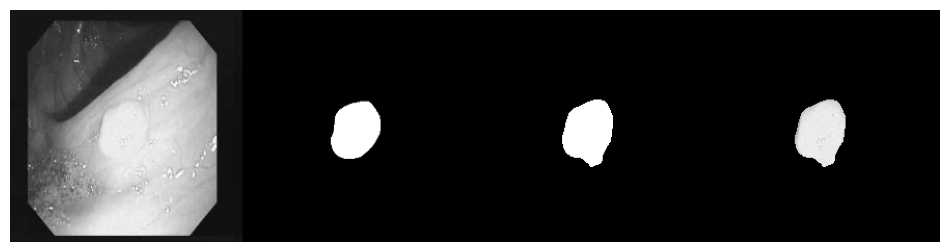

 Epoch: 52 of 100, Iter.: 46 of 46, Train Loss: 0.174564, IoU: 0.888444, Dice: 0.930076
 Epoch: 52 of 100, Iter.: 46 of 46, Valid Loss: 0.382958, IoU: 0.680927, Dice: 0.757878


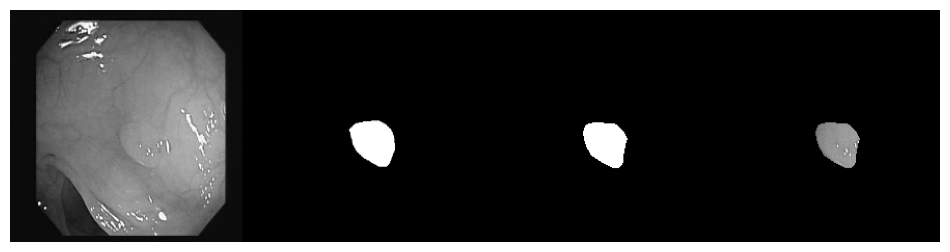

 Epoch: 53 of 100, Iter.: 46 of 46, Train Loss: 0.155947, IoU: 0.912885, Dice: 0.946342
 Epoch: 53 of 100, Iter.: 46 of 46, Valid Loss: 0.402937, IoU: 0.653774, Dice: 0.738645


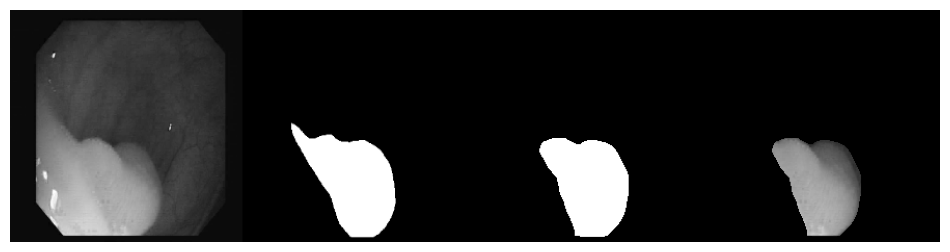

 Epoch: 54 of 100, Iter.: 46 of 46, Train Loss: 0.149137, IoU: 0.914579, Dice: 0.947042
 Epoch: 54 of 100, Iter.: 46 of 46, Valid Loss: 0.365799, IoU: 0.673599, Dice: 0.749319


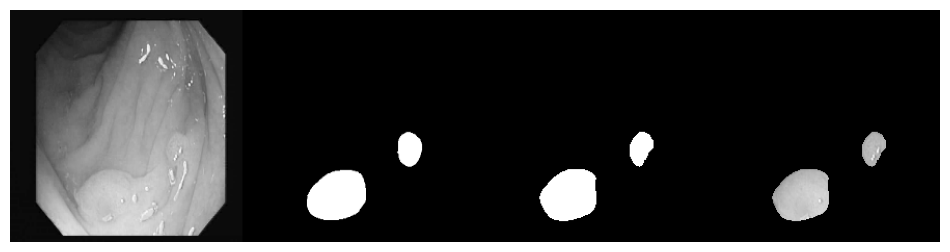

 Epoch: 55 of 100, Iter.: 46 of 46, Train Loss: 0.131948, IoU: 0.928540, Dice: 0.955672
 Epoch: 55 of 100, Iter.: 46 of 46, Valid Loss: 0.360986, IoU: 0.683825, Dice: 0.757960


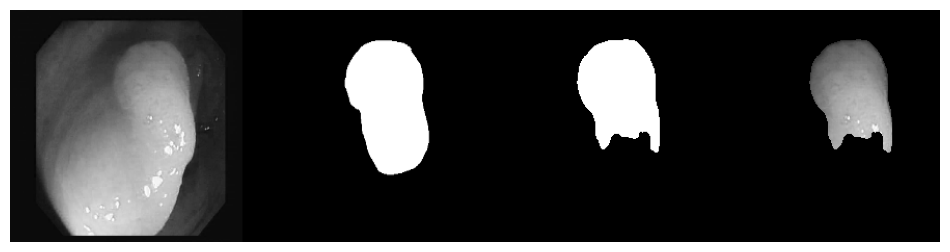

 Epoch: 56 of 100, Iter.: 46 of 46, Train Loss: 0.128626, IoU: 0.937203, Dice: 0.962704
 Epoch: 56 of 100, Iter.: 46 of 46, Valid Loss: 0.351185, IoU: 0.691005, Dice: 0.765827


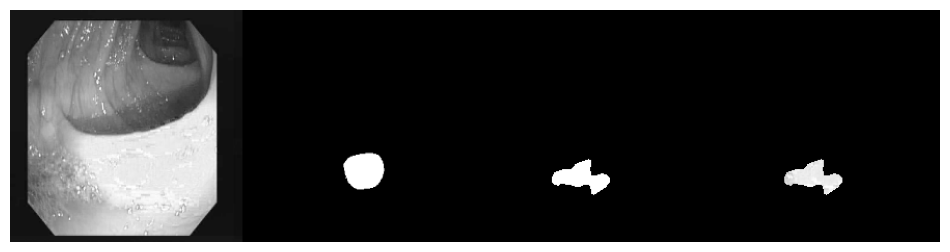

 Epoch: 57 of 100, Iter.: 46 of 46, Train Loss: 0.122390, IoU: 0.940092, Dice: 0.964226
 Epoch: 57 of 100, Iter.: 46 of 46, Valid Loss: 0.342165, IoU: 0.699712, Dice: 0.774555


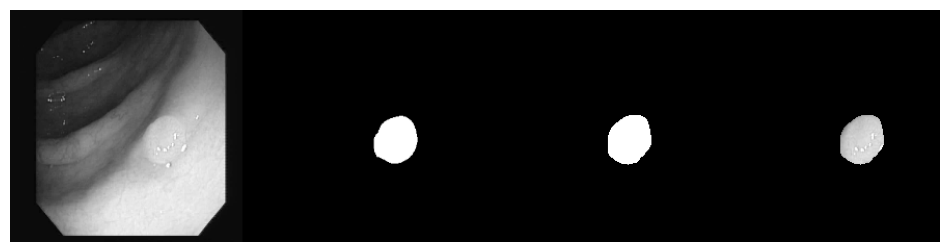

 Epoch: 58 of 100, Iter.: 46 of 46, Train Loss: 0.117724, IoU: 0.945208, Dice: 0.967292
 Epoch: 58 of 100, Iter.: 46 of 46, Valid Loss: 0.338786, IoU: 0.702881, Dice: 0.776515


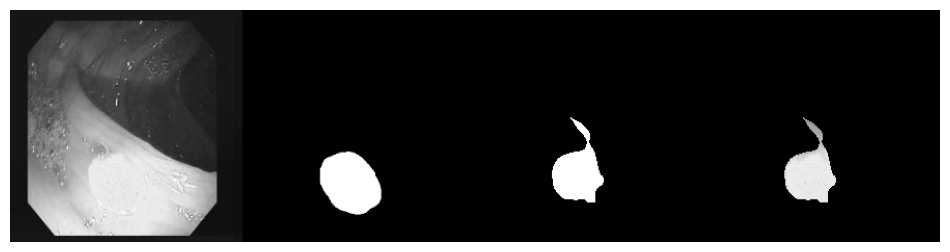

 Epoch: 59 of 100, Iter.: 46 of 46, Train Loss: 0.112082, IoU: 0.948392, Dice: 0.969336
 Epoch: 59 of 100, Iter.: 46 of 46, Valid Loss: 0.352575, IoU: 0.687986, Dice: 0.762771


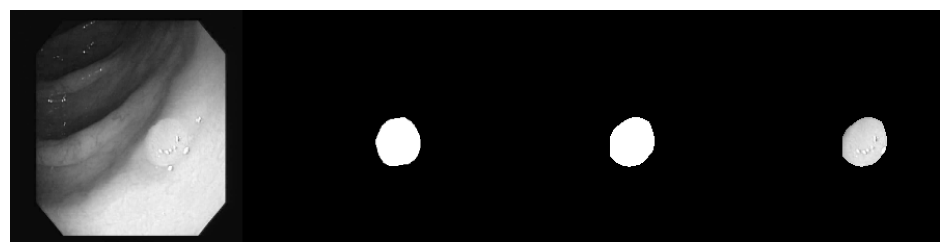

 Epoch: 60 of 100, Iter.: 46 of 46, Train Loss: 0.105644, IoU: 0.950403, Dice: 0.970519
 Epoch: 60 of 100, Iter.: 46 of 46, Valid Loss: 0.337206, IoU: 0.701841, Dice: 0.777398


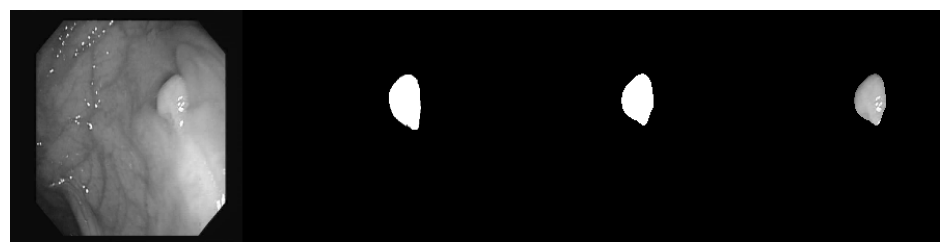

 Epoch: 61 of 100, Iter.: 46 of 46, Train Loss: 0.099513, IoU: 0.951370, Dice: 0.971113
 Epoch: 61 of 100, Iter.: 46 of 46, Valid Loss: 0.338129, IoU: 0.692003, Dice: 0.766999


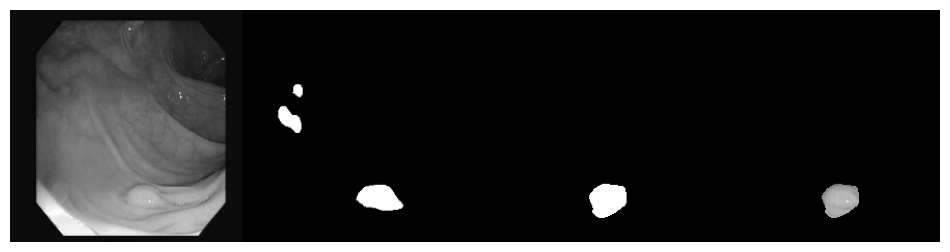

 Epoch: 62 of 100, Iter.: 46 of 46, Train Loss: 0.093600, IoU: 0.952672, Dice: 0.971912
 Epoch: 62 of 100, Iter.: 46 of 46, Valid Loss: 0.335397, IoU: 0.696535, Dice: 0.773277


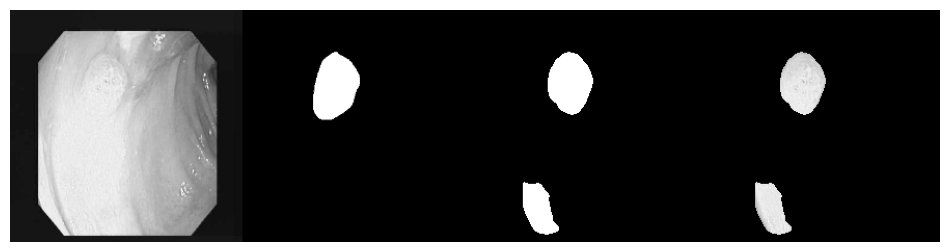

 Epoch: 63 of 100, Iter.: 46 of 46, Train Loss: 0.090877, IoU: 0.951941, Dice: 0.970703
 Epoch: 63 of 100, Iter.: 46 of 46, Valid Loss: 0.327483, IoU: 0.701504, Dice: 0.777592


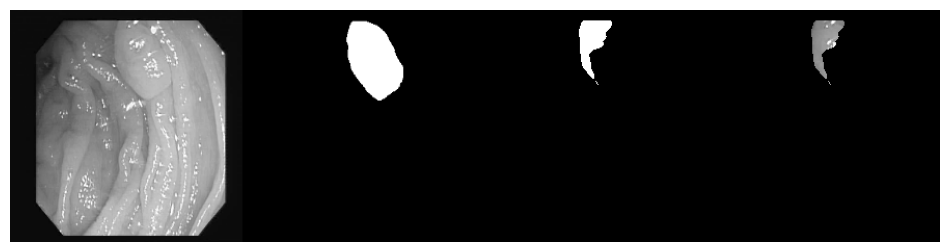

 Epoch: 64 of 100, Iter.: 46 of 46, Train Loss: 0.089781, IoU: 0.956077, Dice: 0.973817
 Epoch: 64 of 100, Iter.: 46 of 46, Valid Loss: 0.332876, IoU: 0.693706, Dice: 0.768477


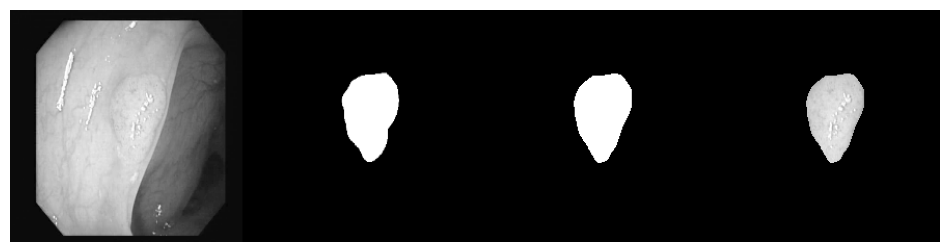

 Epoch: 65 of 100, Iter.: 46 of 46, Train Loss: 0.086328, IoU: 0.957575, Dice: 0.974586
 Epoch: 65 of 100, Iter.: 46 of 46, Valid Loss: 0.334151, IoU: 0.696124, Dice: 0.770488


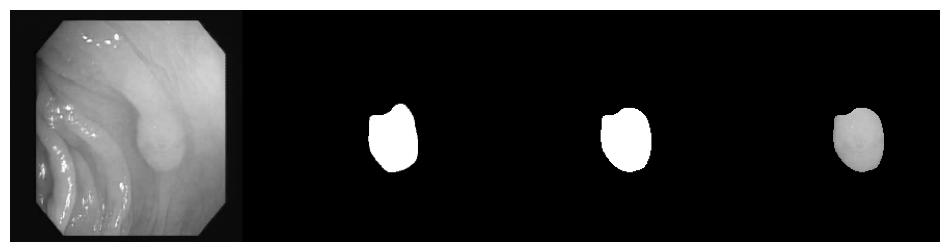

 Epoch: 66 of 100, Iter.: 46 of 46, Train Loss: 0.082707, IoU: 0.956664, Dice: 0.974059
 Epoch: 66 of 100, Iter.: 46 of 46, Valid Loss: 0.331274, IoU: 0.689185, Dice: 0.765741


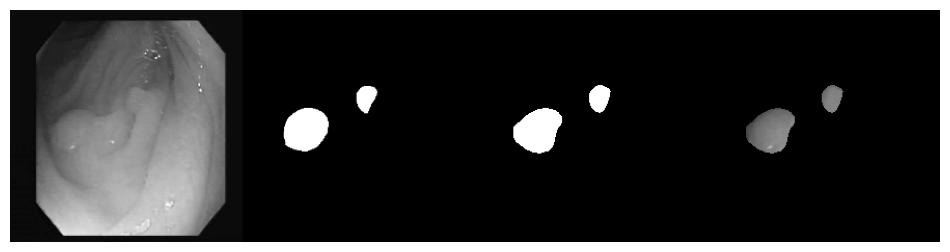

 Epoch: 67 of 100, Iter.: 46 of 46, Train Loss: 0.084005, IoU: 0.956253, Dice: 0.973883
 Epoch: 67 of 100, Iter.: 46 of 46, Valid Loss: 0.328332, IoU: 0.694480, Dice: 0.769731


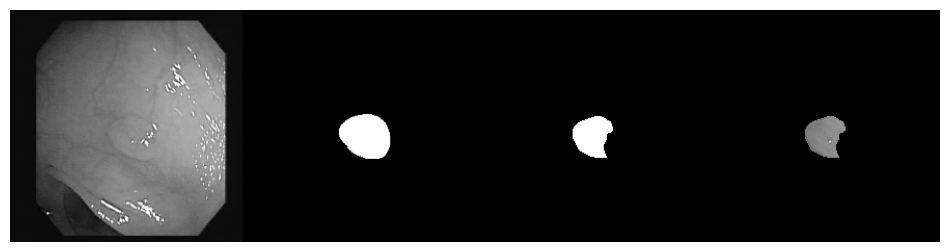

 Epoch: 68 of 100, Iter.: 46 of 46, Train Loss: 0.078633, IoU: 0.958072, Dice: 0.974925
 Epoch: 68 of 100, Iter.: 46 of 46, Valid Loss: 0.324278, IoU: 0.699271, Dice: 0.775606


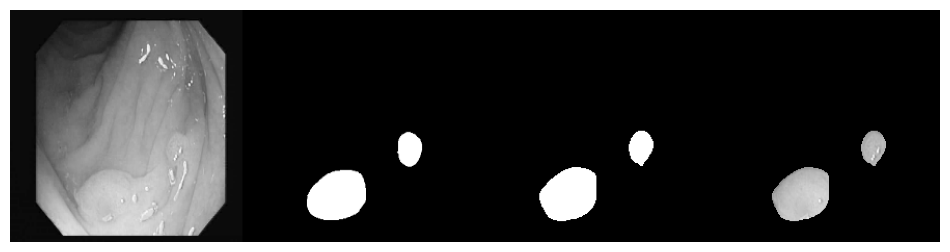

 Epoch: 69 of 100, Iter.: 46 of 46, Train Loss: 0.073660, IoU: 0.958204, Dice: 0.974904
 Epoch: 69 of 100, Iter.: 46 of 46, Valid Loss: 0.328507, IoU: 0.700054, Dice: 0.775185


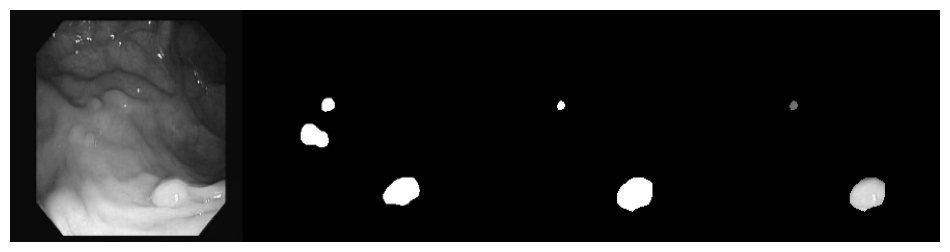

 Epoch: 70 of 100, Iter.: 46 of 46, Train Loss: 0.070673, IoU: 0.959481, Dice: 0.975709
 Epoch: 70 of 100, Iter.: 46 of 46, Valid Loss: 0.320709, IoU: 0.705851, Dice: 0.779583


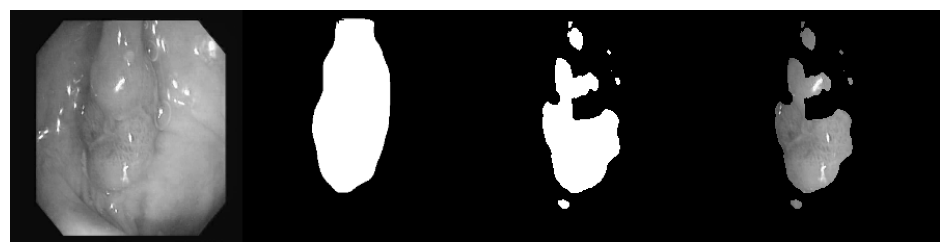

 Epoch: 71 of 100, Iter.: 46 of 46, Train Loss: 0.071422, IoU: 0.958917, Dice: 0.974979
 Epoch: 71 of 100, Iter.: 46 of 46, Valid Loss: 0.326963, IoU: 0.695257, Dice: 0.769469


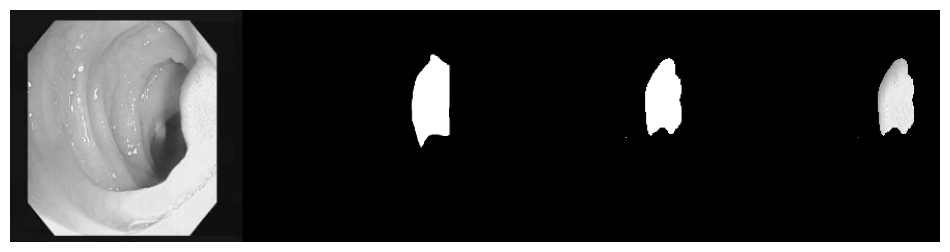

 Epoch: 72 of 100, Iter.: 46 of 46, Train Loss: 0.066577, IoU: 0.959623, Dice: 0.975736
 Epoch: 72 of 100, Iter.: 46 of 46, Valid Loss: 0.332482, IoU: 0.694849, Dice: 0.768046


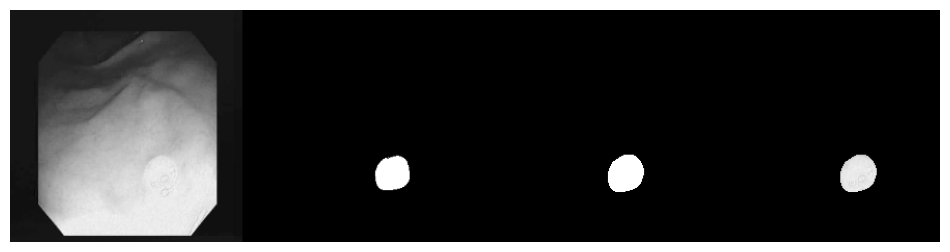

 Epoch: 73 of 100, Iter.: 46 of 46, Train Loss: 0.067588, IoU: 0.960991, Dice: 0.976678
 Epoch: 73 of 100, Iter.: 46 of 46, Valid Loss: 0.333493, IoU: 0.691220, Dice: 0.767108


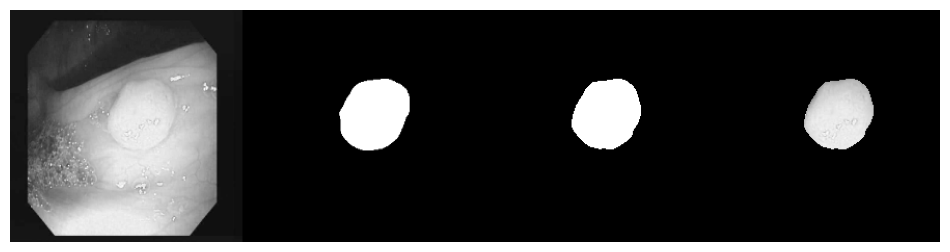

 Epoch: 74 of 100, Iter.: 46 of 46, Train Loss: 0.064288, IoU: 0.962183, Dice: 0.977400
 Epoch: 74 of 100, Iter.: 46 of 46, Valid Loss: 0.314467, IoU: 0.708661, Dice: 0.785792


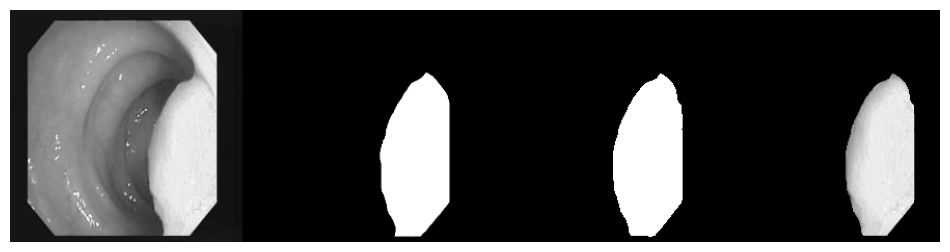

 Epoch: 75 of 100, Iter.: 46 of 46, Train Loss: 0.061239, IoU: 0.963131, Dice: 0.977874
 Epoch: 75 of 100, Iter.: 46 of 46, Valid Loss: 0.316769, IoU: 0.701727, Dice: 0.773472


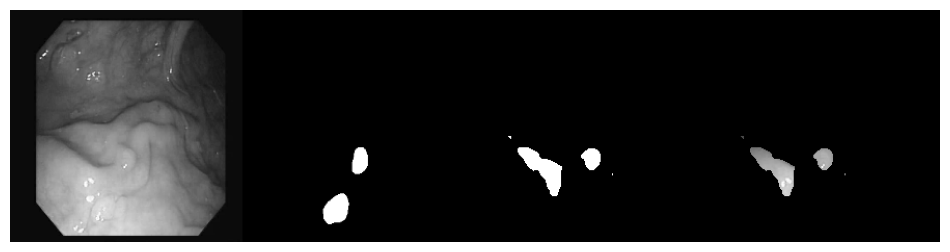

 Epoch: 76 of 100, Iter.: 46 of 46, Train Loss: 0.060083, IoU: 0.962648, Dice: 0.977640
 Epoch: 76 of 100, Iter.: 46 of 46, Valid Loss: 0.319129, IoU: 0.699421, Dice: 0.773557


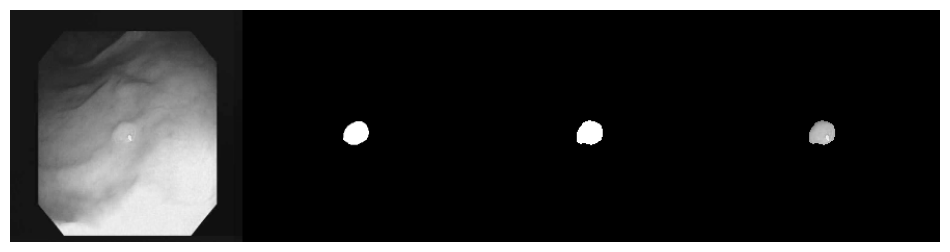

 Epoch: 77 of 100, Iter.: 46 of 46, Train Loss: 0.057764, IoU: 0.962241, Dice: 0.977385
 Epoch: 77 of 100, Iter.: 46 of 46, Valid Loss: 0.338134, IoU: 0.682497, Dice: 0.757522


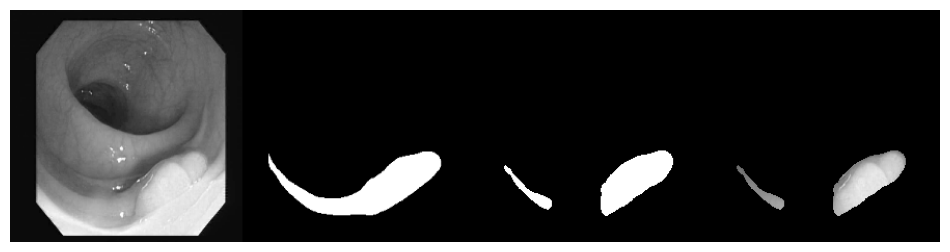

 Epoch: 78 of 100, Iter.: 46 of 46, Train Loss: 0.055768, IoU: 0.965372, Dice: 0.979051
 Epoch: 78 of 100, Iter.: 46 of 46, Valid Loss: 0.323877, IoU: 0.696035, Dice: 0.773166


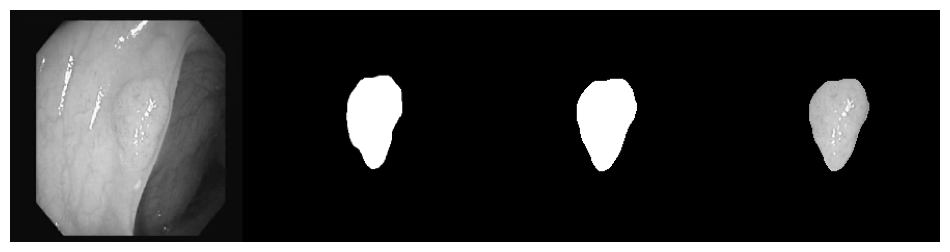

 Epoch: 79 of 100, Iter.: 46 of 46, Train Loss: 0.054814, IoU: 0.964272, Dice: 0.978509
 Epoch: 79 of 100, Iter.: 46 of 46, Valid Loss: 0.327953, IoU: 0.686831, Dice: 0.761183


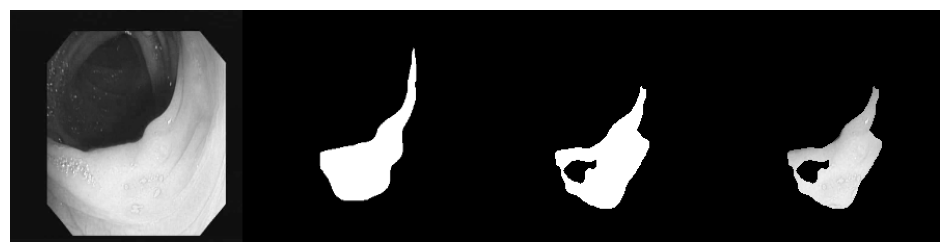

 Epoch: 80 of 100, Iter.: 46 of 46, Train Loss: 0.055060, IoU: 0.961862, Dice: 0.976787
 Epoch: 80 of 100, Iter.: 46 of 46, Valid Loss: 0.318751, IoU: 0.698280, Dice: 0.773236


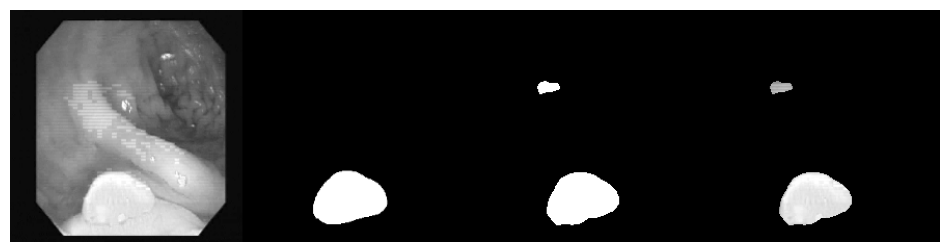

 Epoch: 81 of 100, Iter.: 46 of 46, Train Loss: 0.050503, IoU: 0.964508, Dice: 0.978519
 Epoch: 81 of 100, Iter.: 46 of 46, Valid Loss: 0.321335, IoU: 0.694924, Dice: 0.769431


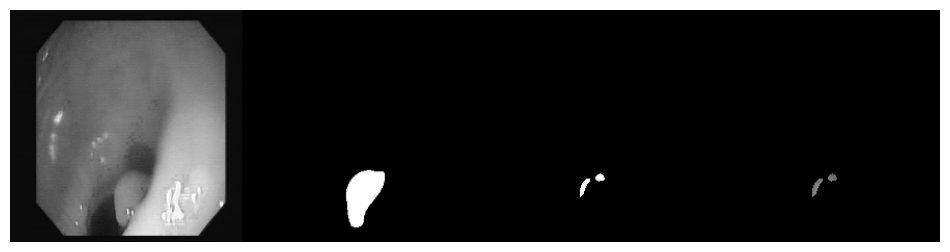

 Epoch: 82 of 100, Iter.: 46 of 46, Train Loss: 0.048990, IoU: 0.966424, Dice: 0.979564
 Epoch: 82 of 100, Iter.: 46 of 46, Valid Loss: 0.318988, IoU: 0.700677, Dice: 0.775158


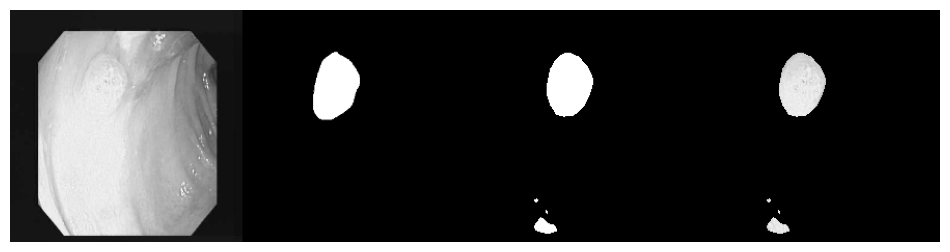

 Epoch: 83 of 100, Iter.: 46 of 46, Train Loss: 0.046921, IoU: 0.967115, Dice: 0.979984
 Epoch: 83 of 100, Iter.: 46 of 46, Valid Loss: 0.298311, IoU: 0.714788, Dice: 0.789341


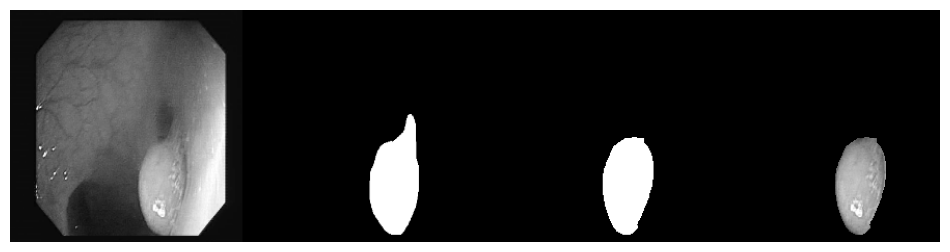

 Epoch: 84 of 100, Iter.: 46 of 46, Train Loss: 0.047262, IoU: 0.966184, Dice: 0.979876
 Epoch: 84 of 100, Iter.: 46 of 46, Valid Loss: 0.329621, IoU: 0.695949, Dice: 0.771643


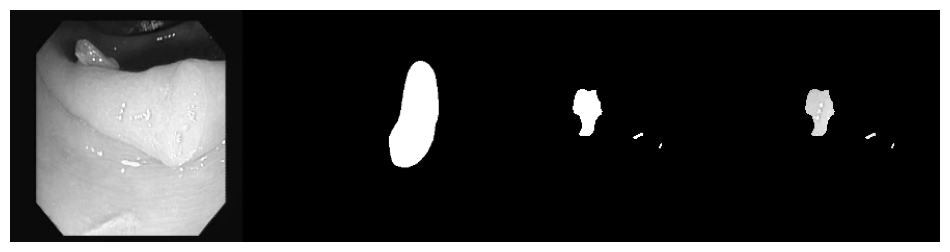

 Epoch: 85 of 100, Iter.: 46 of 46, Train Loss: 0.044760, IoU: 0.968345, Dice: 0.981661
 Epoch: 85 of 100, Iter.: 46 of 46, Valid Loss: 0.308156, IoU: 0.705986, Dice: 0.778575


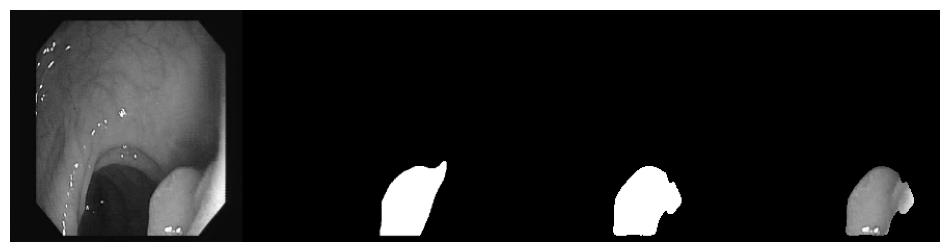

 Epoch: 86 of 100, Iter.: 46 of 46, Train Loss: 0.044144, IoU: 0.969287, Dice: 0.982302
 Epoch: 86 of 100, Iter.: 46 of 46, Valid Loss: 0.318611, IoU: 0.700611, Dice: 0.774523


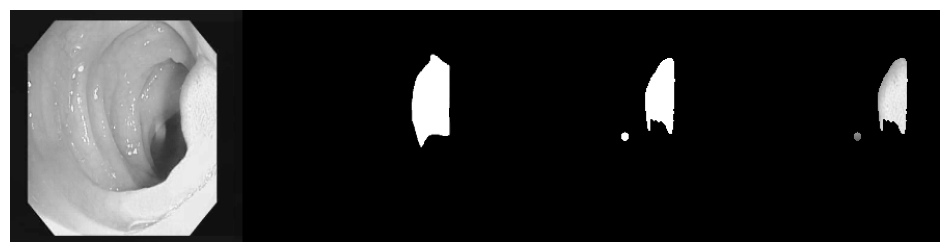

 Epoch: 87 of 100, Iter.: 46 of 46, Train Loss: 0.042152, IoU: 0.970997, Dice: 0.983252
 Epoch: 87 of 100, Iter.: 46 of 46, Valid Loss: 0.312300, IoU: 0.703954, Dice: 0.778489


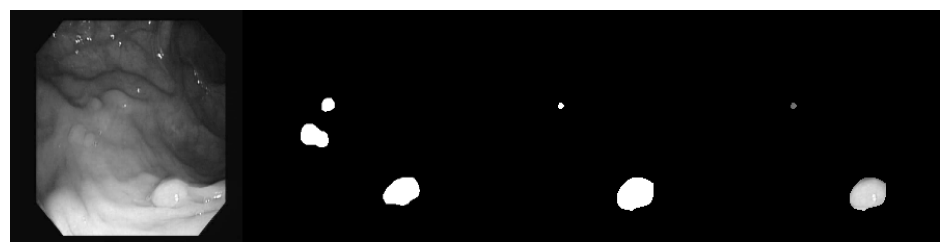

 Epoch: 88 of 100, Iter.: 46 of 46, Train Loss: 0.040919, IoU: 0.970164, Dice: 0.982860
 Epoch: 88 of 100, Iter.: 46 of 46, Valid Loss: 0.303841, IoU: 0.715217, Dice: 0.789472


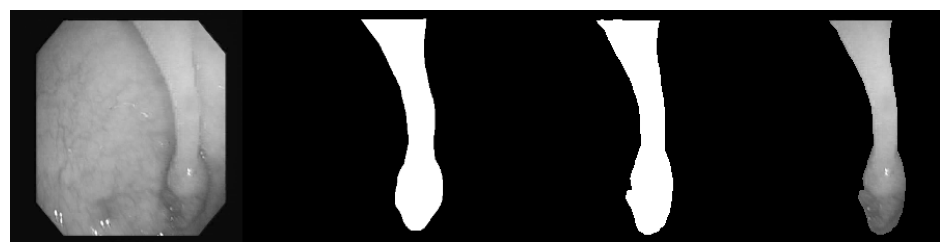

 Epoch: 89 of 100, Iter.: 46 of 46, Train Loss: 0.041067, IoU: 0.971250, Dice: 0.983378
 Epoch: 89 of 100, Iter.: 46 of 46, Valid Loss: 0.307773, IoU: 0.709655, Dice: 0.785056


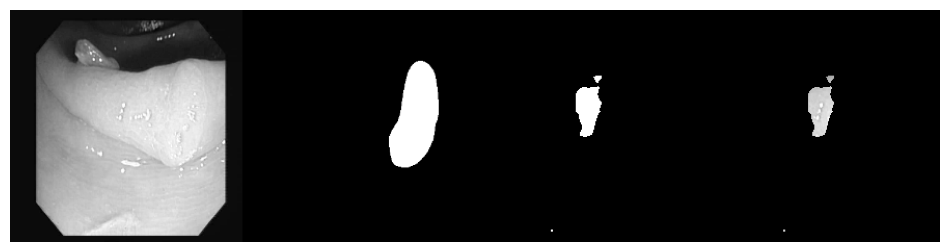

 Epoch: 90 of 100, Iter.: 46 of 46, Train Loss: 0.041419, IoU: 0.968285, Dice: 0.981787
 Epoch: 90 of 100, Iter.: 46 of 46, Valid Loss: 0.311671, IoU: 0.706034, Dice: 0.778731


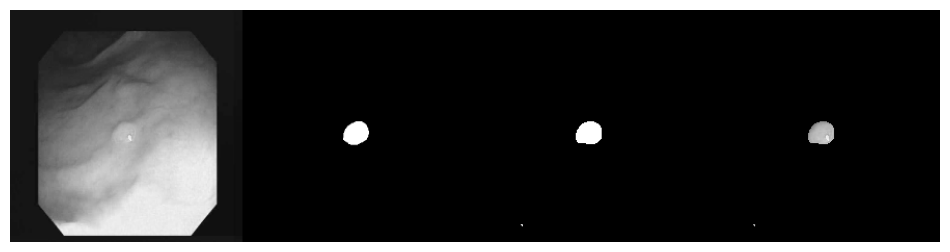

 Epoch: 91 of 100, Iter.: 46 of 46, Train Loss: 0.040577, IoU: 0.969826, Dice: 0.982712
 Epoch: 91 of 100, Iter.: 46 of 46, Valid Loss: 0.305076, IoU: 0.710968, Dice: 0.784059


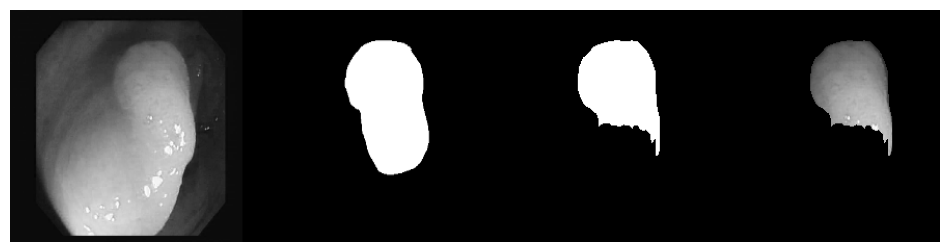

 Epoch: 92 of 100, Iter.: 46 of 46, Train Loss: 0.037961, IoU: 0.970416, Dice: 0.982984
 Epoch: 92 of 100, Iter.: 46 of 46, Valid Loss: 0.303421, IoU: 0.714402, Dice: 0.789174


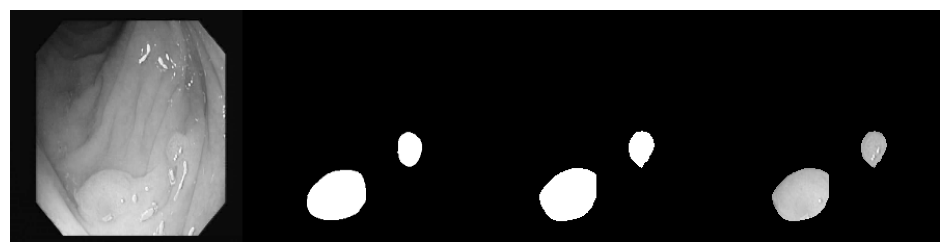

 Epoch: 93 of 100, Iter.: 46 of 46, Train Loss: 0.035123, IoU: 0.972460, Dice: 0.984047
 Epoch: 93 of 100, Iter.: 46 of 46, Valid Loss: 0.316970, IoU: 0.703610, Dice: 0.778086


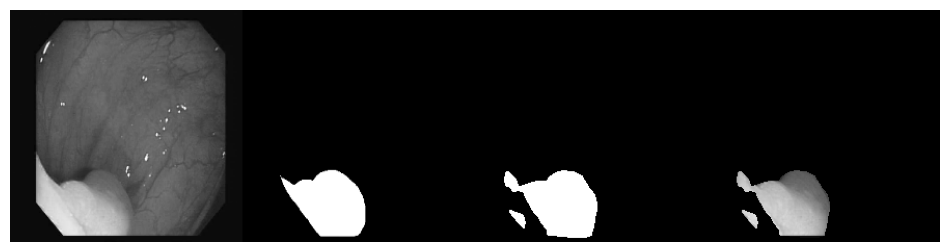

 Epoch: 94 of 100, Iter.: 46 of 46, Train Loss: 0.038521, IoU: 0.970905, Dice: 0.983246
 Epoch: 94 of 100, Iter.: 46 of 46, Valid Loss: 0.317051, IoU: 0.699262, Dice: 0.773668


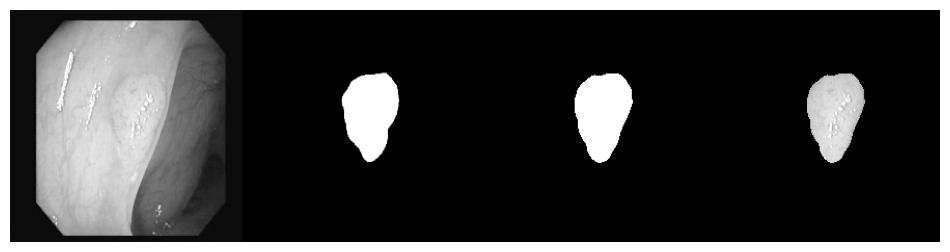

 Epoch: 95 of 100, Iter.: 46 of 46, Train Loss: 0.036531, IoU: 0.969061, Dice: 0.982234
 Epoch: 95 of 100, Iter.: 46 of 46, Valid Loss: 0.305512, IoU: 0.698529, Dice: 0.774098


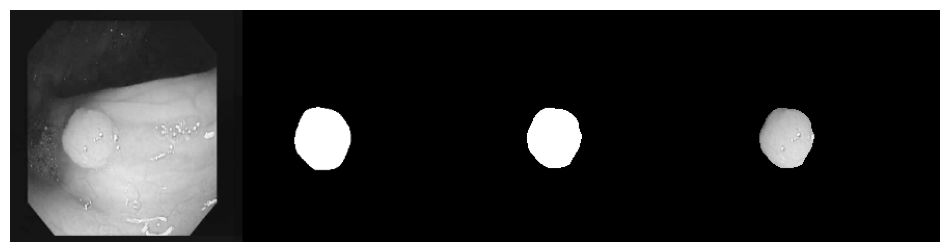

 Epoch: 96 of 100, Iter.: 46 of 46, Train Loss: 0.036194, IoU: 0.969049, Dice: 0.981999
 Epoch: 96 of 100, Iter.: 46 of 46, Valid Loss: 0.310501, IoU: 0.706174, Dice: 0.779938


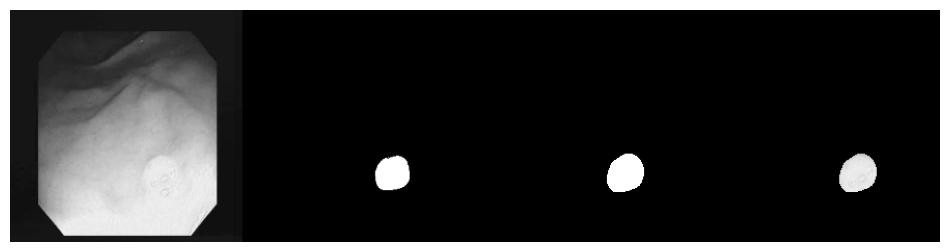

 Epoch: 97 of 100, Iter.: 46 of 46, Train Loss: 0.034664, IoU: 0.972407, Dice: 0.984041
 Epoch: 97 of 100, Iter.: 46 of 46, Valid Loss: 0.305846, IoU: 0.703611, Dice: 0.778776


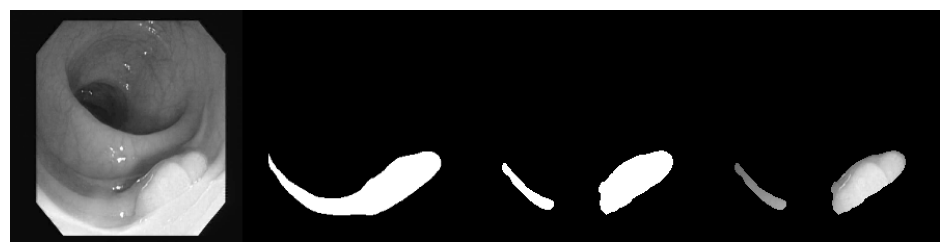

 Epoch: 98 of 100, Iter.: 46 of 46, Train Loss: 0.033174, IoU: 0.971322, Dice: 0.983049
 Epoch: 98 of 100, Iter.: 46 of 46, Valid Loss: 0.306579, IoU: 0.707786, Dice: 0.783769


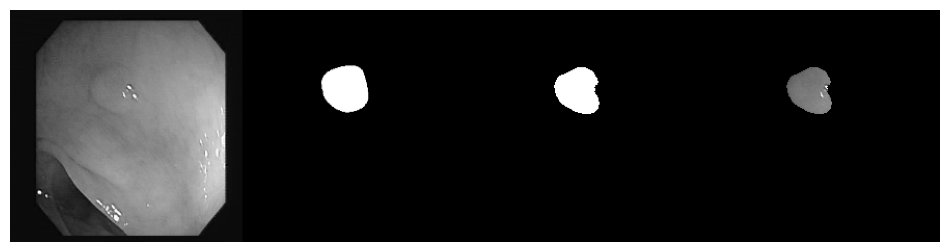

 Epoch: 99 of 100, Iter.: 46 of 46, Train Loss: 0.032092, IoU: 0.973921, Dice: 0.984853
 Epoch: 99 of 100, Iter.: 46 of 46, Valid Loss: 0.332423, IoU: 0.694559, Dice: 0.768474


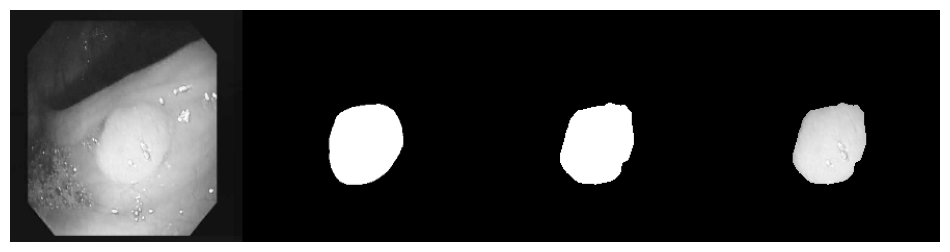

 Epoch: 100 of 100, Iter.: 46 of 46, Train Loss: 0.032036, IoU: 0.973123, Dice: 0.984334
 Epoch: 100 of 100, Iter.: 46 of 46, Valid Loss: 0.319871, IoU: 0.696581, Dice: 0.770526


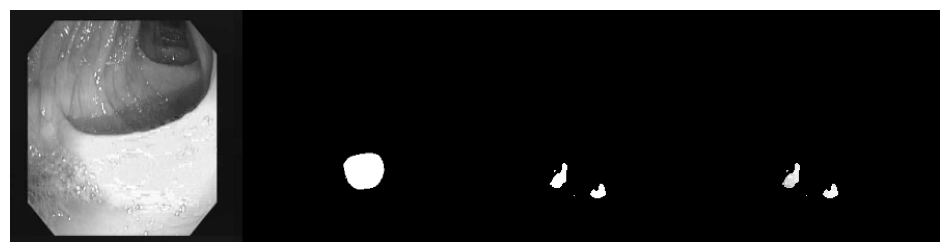

CPU times: user 11min 50s, sys: 12min 17s, total: 24min 7s
Wall time: 17min 8s


In [15]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:88, Best_IOU:0.7152, Best_DiceScore:0.7895


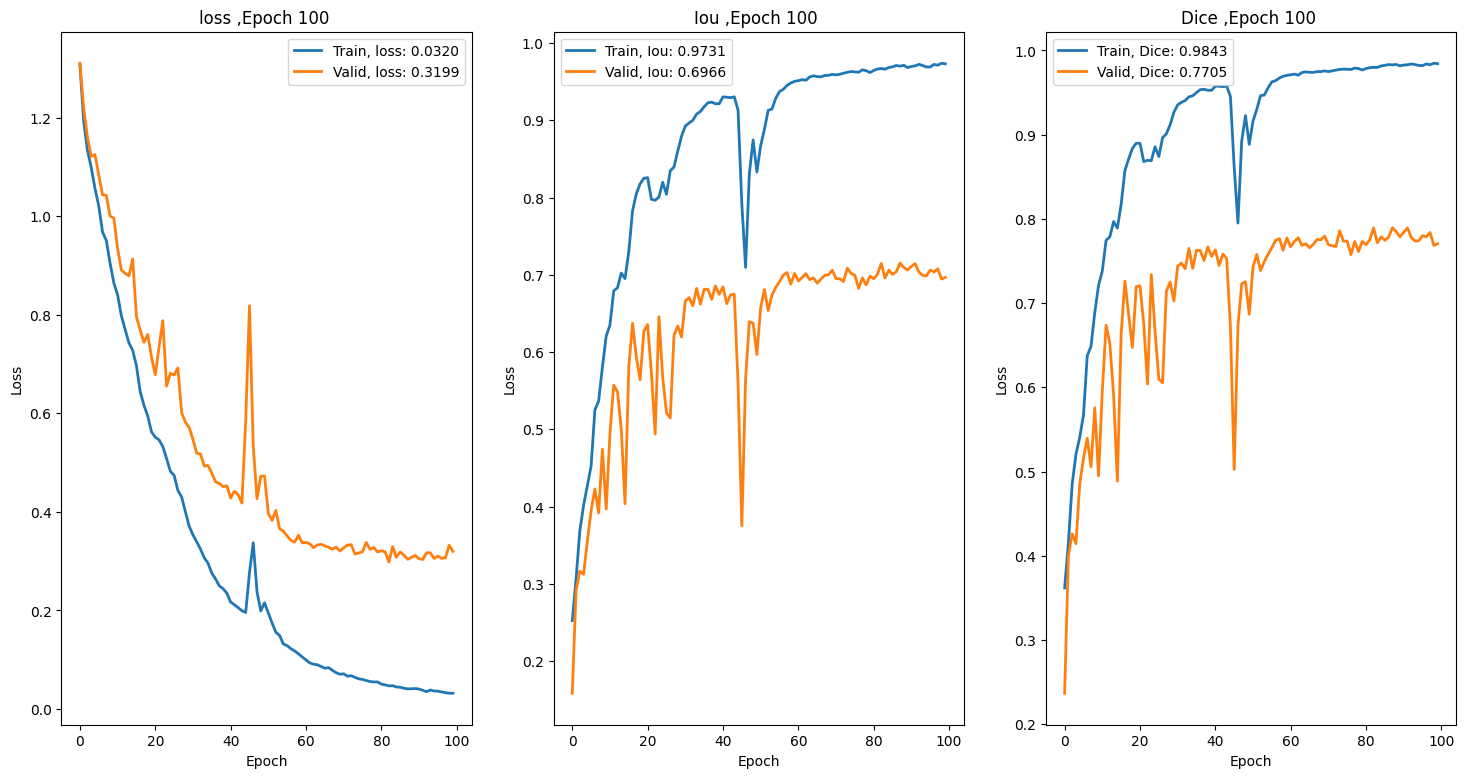

In [16]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()